# Laboratorio 6
### Universidad del Valle de Guatemala
### Security Data Science

Andrés de la Roca - 20332

#### Preaumbulo

In [43]:
# Importacion de librerias
from scapy.all import *
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Captura de paquetes (25 paquetes)
num_packets = 25
pcap = sniff(count=num_packets)

print("Tipo de dato de pcap: ", type(pcap))
print("Numero de paquetes: ", len(pcap))
print("Contenido: ")
print(pcap)

Tipo de dato de pcap:  <class 'scapy.plist.PacketList'>
Numero de paquetes:  25
Contenido: 
<Sniffed: TCP:2 UDP:23 ICMP:0 Other:0>


In [45]:
# Mostrar primer paquete
print("Primer paquete: ")
print(pcap[0].show())

Primer paquete: 
###[ Ethernet ]### 
  dst       = e4:f7:5b:22:aa:bd
  src       = 58:6c:25:ff:3f:b6
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0xb8
     len       = 164
     id        = 55388
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = udp
     chksum    = 0x0
     src       = 192.168.1.13
     dst       = 170.72.190.47
     \options   \
###[ UDP ]### 
        sport     = 63031
        dport     = 9000
        len       = 144
        chksum    = 0x498b
###[ Raw ]### 
           load      = '\\x91\\xe5\\x9d$\\xffj\\x99\\xb0\x1e\\x8c#-X\\xbd\\\x00\\xbe\\xde\x00\x06\x10\x00 \\xffF\x00-p\\xd565\\xa0g\x00\x05uM\\xf7\\xce\\xd9\x16\x00\x00\x00\\xc5v\\xc5\\xf2\\xc9g\\xfd$\\xe1T\\xa2\\xfc\\x99\x1b\\xa2w\\xe6\\xe5\x15\\x83\'\\xff\\x81\\xe8@\\xcfdo\\x8a\x00\\xf8\\xb0\\xe6\\x9c\\xfegj\x1cj\\x9b\\xe5\\x96\x1d\\x870\\x8b?\'\\xa0\\xbb\x05\\xc5lH\\x8d\\xd6\\xdaUٸ\\xd6Њ\ue4e3\\x82\\xd4`\\xbf\\xd5q\\x8b\\xf9G\\x95ŕř\\xc8\x11\\x

In [46]:
# Mostrar informacion de 5 paquetes
print("Informacion de 5 paquetes: ")
for i in range(5):
    print("Paquete ", i+1)
    print(pcap[i].show())


Informacion de 5 paquetes: 
Paquete  1
###[ Ethernet ]### 
  dst       = e4:f7:5b:22:aa:bd
  src       = 58:6c:25:ff:3f:b6
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0xb8
     len       = 164
     id        = 55388
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = udp
     chksum    = 0x0
     src       = 192.168.1.13
     dst       = 170.72.190.47
     \options   \
###[ UDP ]### 
        sport     = 63031
        dport     = 9000
        len       = 144
        chksum    = 0x498b
###[ Raw ]### 
           load      = '\\x91\\xe5\\x9d$\\xffj\\x99\\xb0\x1e\\x8c#-X\\xbd\\\x00\\xbe\\xde\x00\x06\x10\x00 \\xffF\x00-p\\xd565\\xa0g\x00\x05uM\\xf7\\xce\\xd9\x16\x00\x00\x00\\xc5v\\xc5\\xf2\\xc9g\\xfd$\\xe1T\\xa2\\xfc\\x99\x1b\\xa2w\\xe6\\xe5\x15\\x83\'\\xff\\x81\\xe8@\\xcfdo\\x8a\x00\\xf8\\xb0\\xe6\\x9c\\xfegj\x1cj\\x9b\\xe5\\x96\x1d\\x870\\x8b?\'\\xa0\\xbb\x05\\xc5lH\\x8d\\xd6\\xdaUٸ\\xd6Њ\ue4e3\\x82\\xd4`\\xbf\\xd5q\\x8b\\x

#### Análisis Estadístico

In [47]:
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

# Lectura de archivo PCAP
pcap = rdpcap('./Referencias/analisis_paquetes.pcap')

print(pcap)

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>


In [48]:
# Creacion de DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])

    field_values.append(packet.time)

    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)

    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)


df = df.reset_index()
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   961      1          0   64    17  21222  ...    None   
1       4   5  32    84  58919          0  122    17  13836  ...    None   
2       4   5   0   975      1          0   64    17  21208  ...    None   
3       4   5  32    84  59493          0  122    17  13262  ...    None   
4       4   5   0  1012      1          0   64    17  21171  ...    None   

  reserved flags window chksum urgptr options payload  \
0     None  None   None  62990   None    None     933   
1     None  None   None  65061   None    None      56   
2     None  None   None  36378   None    None     947   
3     None  None   None  65063   None    None      56   
4     None  None   None  63846   None    None     984   

                                         payload_raw  \
0  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
1  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...   
2  b'\x00\x0c\x01\x00\x00\x01\x0

In [49]:
# Valores de columnas Src address, Dst address, src port, dst port
print("Valores de columnas Src address, Dst address, src port, dst port")
print(df['src'].value_counts())
print(df['dst'].value_counts())
print(df['sport'].value_counts())
print(df['dport'].value_counts())

Valores de columnas Src address, Dst address, src port, dst port
10.1.10.53     31
84.54.22.33    29
75.75.75.75     2
Name: src, dtype: int64
10.1.10.53     31
84.54.22.33    29
75.75.75.75     2
Name: dst, dtype: int64
53       60
15812     1
23903     1
Name: sport, dtype: int64
53       60
15812     1
23903     1
Name: dport, dtype: int64


In [50]:
# Mostrar todas las ip origen
print("IPs origen: ")
print(df['src'].unique())

IPs origen: 
['10.1.10.53' '84.54.22.33' '75.75.75.75']


In [51]:
# Mostrar todas la ip destino
print("IPs destino: ")
print(df['dst'].unique())

IPs destino: 
['84.54.22.33' '10.1.10.53' '75.75.75.75']


In [52]:
# Que puertos se estan utilizando
print("Puertos origen: ")
print(df['sport'].unique())

Puertos origen: 
[53 15812 23903]


In [53]:
# Cual es la ip origen que mas paquetes envia
print("IP origen que mas paquetes envia: ")
IP_mas_envia = df['src'].value_counts().idxmax()
print(IP_mas_envia)

# Cual es la ip destino que mas paquetes recibe de la ip anterior
print("IP destino que mas paquetes recibe de la ip anterior: ")
df_IP_mas_envia = df[df['src'] == IP_mas_envia]
IP_mas_recibe = df_IP_mas_envia['dst'].value_counts().idxmax()
print(IP_mas_recibe)

# Que puertos utilizan para comunicarse
print("Puertos utilizados para comunicarse: ")
puertos_utilizados = df_IP_mas_envia['sport'].unique()
print(puertos_utilizados)


IP origen que mas paquetes envia: 
10.1.10.53
IP destino que mas paquetes recibe de la ip anterior: 
84.54.22.33
Puertos utilizados para comunicarse: 
[53 15812 23903]


Graficas

Grafica de barras 2D horizontales, eje Y = IP origen, eje X = suma de payloads enviados


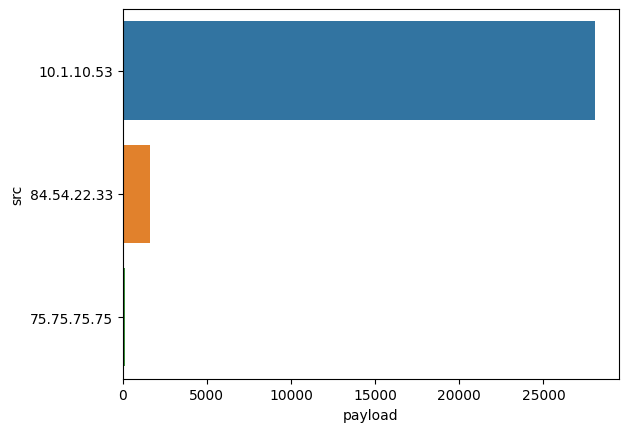

In [54]:
# Grafica de barras 2D horizontales, eje Y = IP origen, eje X = suma de payloads enviados
print("Grafica de barras 2D horizontales, eje Y = IP origen, eje X = suma de payloads enviados")
df_plot = df.groupby('src').sum()
df_plot['src'] = df_plot.index
df_plot = df_plot.sort_values('payload', ascending=False)
sns.barplot(x='payload', y='src', data=df_plot)
plt.show()


Grafica de barras 2D horizontales en el eje Y = IP destino, eje X = suma de payloads recibidos


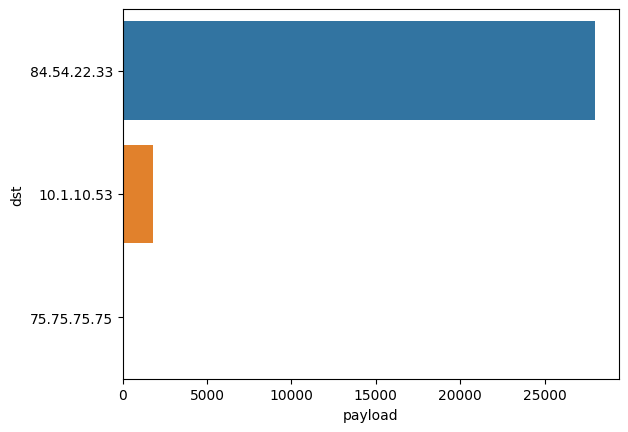

In [55]:
# Grafica de barras 2D horizontales en el eje Y = IP destino, eje X = suma de payloads recibidos
print("Grafica de barras 2D horizontales en el eje Y = IP destino, eje X = suma de payloads recibidos")
df_plot = df.groupby('dst').sum()
df_plot['dst'] = df_plot.index
df_plot = df_plot.sort_values('payload', ascending=False)
sns.barplot(x='payload', y='dst', data=df_plot)
plt.show()

In [56]:
print(df['src'].value_counts())

10.1.10.53     31
84.54.22.33    29
75.75.75.75     2
Name: src, dtype: int64


In [57]:
print(df['sport'].value_counts())

53       60
15812     1
23903     1
Name: sport, dtype: int64


Grafica de barras 2D horizontales en el eje Y = Puerto origen, eje X = suma de payloads enviados


<AxesSubplot: xlabel='payload', ylabel='sport'>

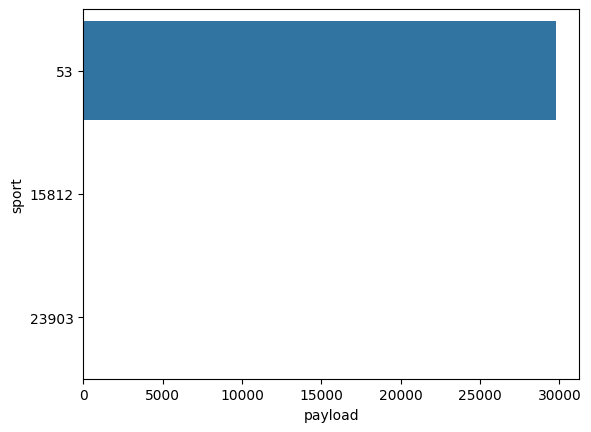

In [58]:
# Grafica de barras 2D horizontales en el eje Y = Puerto origen, eje X = suma de payloads enviados
print("Grafica de barras 2D horizontales en el eje Y = Puerto origen, eje X = suma de payloads enviados")
df_plot = df.groupby('sport').sum()
df_plot['sport'] = df_plot.index
df_plot = df_plot.sort_values('payload', ascending=False)
sns.barplot(x='payload', y='sport', data=df_plot, orient='h')


Grafica de barras 2D horizontales en el eje Y = Puerto destino, eje X = suma de payloads recibidos


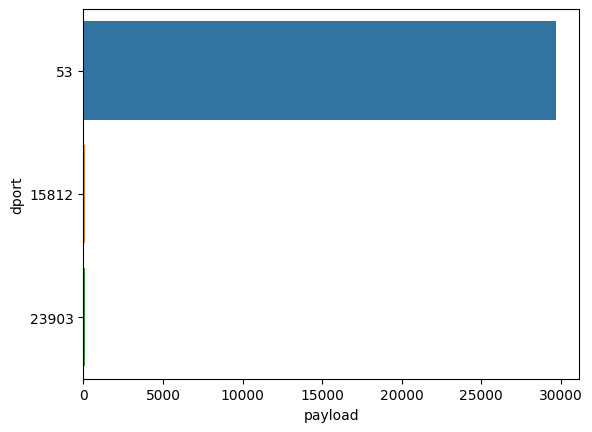

In [59]:
# Grafica de barras 2D horizontales en el eje Y = Puerto destino, eje X = suma de payloads recibidos
print("Grafica de barras 2D horizontales en el eje Y = Puerto destino, eje X = suma de payloads recibidos")
df_plot = df.groupby('dport').sum()
df_plot['dport'] = df_plot.index
df_plot = df_plot.sort_values('payload', ascending=False)
sns.barplot(x='payload', y='dport', data=df_plot, orient='h')
plt.show()

Grafica de barras 2D verticales en el eje Y = suma de payloads, eje X el tiempo, para la IP origen que mas paquetes envia


C:\Users\Andrès DLR\AppData\Local\Temp\ipykernel_28168\3365665740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['time'] = df_plot['time'].astype(float)


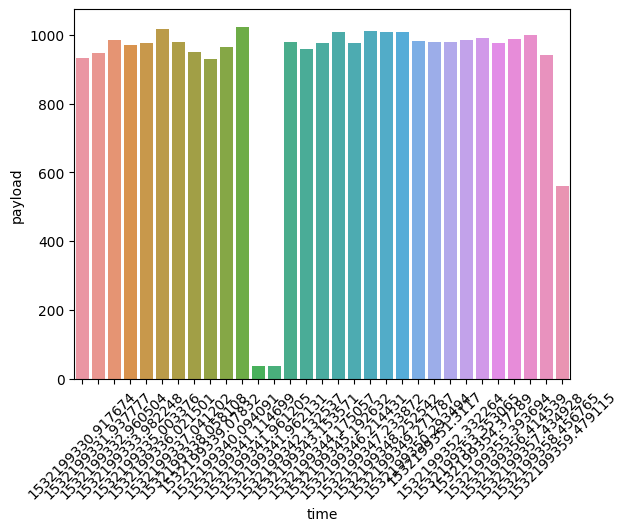

In [60]:
# Grafica de barras 2D verticales en el eje Y = suma de payloads, eje X el tiempo, para la IP origen que mas paquetes envia
print("Grafica de barras 2D verticales en el eje Y = suma de payloads, eje X el tiempo, para la IP origen que mas paquetes envia")
df_plot = df[df['src'] == IP_mas_envia]

# Convert time into float
df_plot['time'] = df_plot['time'].astype(float)

sns.barplot(x='time', y='payload', data=df_plot)
# Rotar las etiquetas del eje X
plt.xticks(rotation=45)
plt.show()


<b>Utilizando la información de las estadísticas y la información del comportamiento del
tráfico que las gráficas muestran, describa que es lo que está sucediendo. ¿Es común
el comportamiento?<b>

R/.  
Segun las estadisticas observadas, se puede observar un aumento desproporcionado del envio de payloads desde la IP 10.1.10.53 hacia la IP 84.54.22.33, en especifico hacia el puerto 53. Esto se puede considerar como una anomalia debido a la cantidad de payloads masiva que se esta enviando hacia un solo puerto. Adicionalmente, en la grafica de la cantidad de payloads enviados por hora se puede observar que hay varias entradas que se acercan al tipico "rate limit" de 1000 peticiones por hora, lo cual podria indicar que se esta intentando saturar el servicio de DNS de la red.  

 Este comportamiento no es comun y podria estar relacionado con un ataque de denegacion de servicio, dirigido especificamente hacia el servicio de DNS de la red, ya que el puerto 53 es el puerto por defecto para manejar este servicio.

 Es importante realizar una investigacion mas profunda para determinar al 100% si se trata de un ataque o si es solo un comportamiento anormal de la red.

#### Investigacion del payload

In [61]:
# Dataframe unicamente con conexiones que incluyan la direccion ip origen que mas paquetes envia
df_IP_mas_envia = df[df['src'] == IP_mas_envia]
df_IP_mas_envia = df_IP_mas_envia[df_IP_mas_envia['dst'] == IP_mas_recibe]
print(df_IP_mas_envia)

   version ihl tos   len id flags frag ttl proto chksum  ... dataofs reserved  \
0        4   5   0   961  1          0  64    17  21222  ...    None     None   
2        4   5   0   975  1          0  64    17  21208  ...    None     None   
4        4   5   0  1012  1          0  64    17  21171  ...    None     None   
6        4   5   0   998  1          0  64    17  21185  ...    None     None   
8        4   5   0  1003  1          0  64    17  21180  ...    None     None   
10       4   5   0  1045  1          0  64    17  21138  ...    None     None   
12       4   5   0  1008  1          0  64    17  21175  ...    None     None   
14       4   5   0   979  1          0  64    17  21204  ...    None     None   
16       4   5   0   959  1          0  64    17  21224  ...    None     None   
18       4   5   0   992  1          0  64    17  21191  ...    None     None   
20       4   5   0  1051  1          0  64    17  21132  ...    None     None   
26       4   5   0  1006  1 

In [62]:
df_IP_mas_envia['src'].value_counts()

10.1.10.53    29
Name: src, dtype: int64

In [63]:
df_IP_mas_envia['payload']

0      933
2      947
4      984
6      970
8      975
10    1017
12     980
14     951
16     931
18     964
20    1023
26     978
28     958
30     976
32    1009
34     976
36    1011
38    1009
40    1007
42     982
44     978
46     978
48     985
50     991
52     977
54     989
56     999
58     941
60     560
Name: payload, dtype: object

In [65]:
df_data = df_IP_mas_envia.groupby('dst')['payload'].sum().reset_index()
df_data

,dst,payload
0,84.54.22.33,27979


In [70]:
df_data['payload'] = pd.to_numeric(df_data['payload'])

In [73]:
# Obtener la IP destino con mayor payload intercambiado
indice_max = df_data['payload'].idxmax()
fila_max = df_data.iloc[indice_max]
print('IP con mayor intercambio de paquetes:', fila_max['dst'])

IP con mayor intercambio de paquetes: 84.54.22.33


In [74]:
# Crear un DF con la conversacion entre la IP origen y la IP destino con mayor payload intercambiado
df_conversacion = df_IP_mas_envia[df_IP_mas_envia['dst'] == fila_max['dst']]
print(df_conversacion)

   version ihl tos   len id flags frag ttl proto chksum  ... dataofs reserved  \
0        4   5   0   961  1          0  64    17  21222  ...    None     None   
2        4   5   0   975  1          0  64    17  21208  ...    None     None   
4        4   5   0  1012  1          0  64    17  21171  ...    None     None   
6        4   5   0   998  1          0  64    17  21185  ...    None     None   
8        4   5   0  1003  1          0  64    17  21180  ...    None     None   
10       4   5   0  1045  1          0  64    17  21138  ...    None     None   
12       4   5   0  1008  1          0  64    17  21175  ...    None     None   
14       4   5   0   979  1          0  64    17  21204  ...    None     None   
16       4   5   0   959  1          0  64    17  21224  ...    None     None   
18       4   5   0   992  1          0  64    17  21191  ...    None     None   
20       4   5   0  1051  1          0  64    17  21132  ...    None     None   
26       4   5   0  1006  1 

In [75]:
# Guardar los payloads en un array cada uno
payloads = df_conversacion['payload_raw'].values
print(payloads)

[b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xb

<b>Observe los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envíe al puerto destino? Describa lo que encontró.<b>

R/.  
Se puede observar que los primeros bytes del contenido de los payloads es bastante similar entre todos, lo que en un principio podria indicar algo sospechoso, sin embargo, al analizar el contenido a detalle, se puede observar que los payloads son peticiones que varian de payload a payload, lo que posiblemente puede indicar que mientras hay un trafico bastante alto dentro de esa red, no necesariamente se trate de un ataque de denegacion de servicio.